# Control theory. Course introduction.

## TP3. Controllability and Observability
## Study load

Course grade breakdown:

    Labs - 40%
    
    Final project presentation 30%

    Final test 30%
    
File name for lab submission: yourname_labnumber.ipynb (example: elenavanneaux_TP2.ipynb)    

The completed notebooks should be **submitted via the corresponding Moodle assignments before the beginning of the next session.**

## Prerequisites for practice
### Math
During the course, we will cover the following areas of mathematics:
    
    1. Linear Algebra

    2. Calculus

    3. Differential equations

    4. Dynamics (Mechanics and Physics)

### Python programming
In the labs we will use a Python programming language and the following libraries:

    1. NumPy https://numpy.org/doc/stable/

    2. SciPy https://docs.scipy.org/doc/scipy/

    3. Matplotlib https://matplotlib.org/stable/tutorials/index

    4. SymPy https://docs.sympy.org/latest/tutorials/intro-tutorial/intro.html

    5. Control System Library https://python-control.readthedocs.io/en/0.10.1/intro.html

### Jupyter Notebook Markdown Cells Documentation

Please check on Markdown cells documentation, to provide a fancy look for your notebooks!

https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html

## Code template

In [73]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# x is a state vecot, t is a current time, A is a dynamic matrix, B is a control matrix, D is a disturbance matrix, 
# u_func(t) is a control input, w_func(t) is a disturbance input 
def StateSpace(x, t, A, B, D, u_func, w_func):
    w = w_func(t)
    u = u_func(t)
    return np.dot(A, x) + np.dot(B, u).flatten() + np.dot(D, w).flatten()

# OpenLoopInputOutputSystem with time-dependent w(t)
def OpenLoopInputOutputSystem(A, B, D, C, u_func, w_func, T, x0):
    # Solve the ODE system with odeint, passing the time-dependent w function
    solution = odeint(StateSpace, x0, T, args=(A, B, D, u_func, w_func))
    # Output calculation using C and the solution
    # return (C @ solution.T) 
    return (solution.T) 

def PID(A, B, D, C, Kp, Ki, Kd, r_func, w_func, T, x0):
    z0 = np.array([[0.0]])
    x_a =  np.block([[x0.reshape(-1,1)],[z0]])
    M = np.eye(x0.shape[0]) + Kd*B @ C
    A_a = np.block([[np.linalg.inv(M) @ (A - Kp * B @ C), -Ki * np.linalg.inv(M) @ B ], [C, np.array([0.0])]])
    B_a =  np.block([[Kp * np.linalg.inv(M) @ B ], [np.array([1.0])]])
    D_a = np.block([[np.linalg.inv(M) @ D],[np.array([[0.0]])]])
    C_a = np.block([C, np.array([[0.0]])])
    return OpenLoopInputOutputSystem(A_a, B_a, D_a, C_a, r_func, w_func, T, x_a.flatten()).T

Text(0, 0.5, 'Position ')

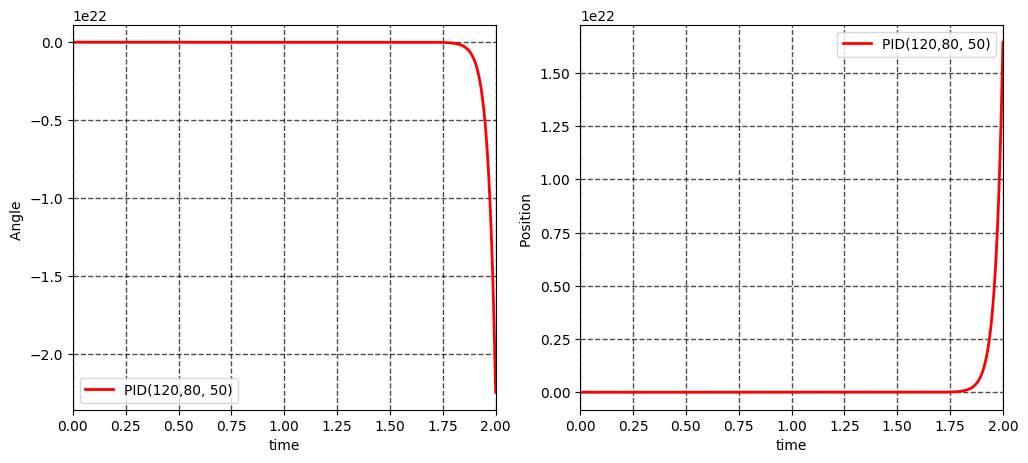

In [82]:
import sympy as sp
from matplotlib.pyplot import *
# Answer to EX1 q1 using symbolic calculus
# Define symbolic variables
M, m, b, l, I, g, F = sp.symbols('M m b l I g F')
y, y1, theta, theta1, doty1, dottheta1 = sp.symbols('y y1 theta theta1 doty1 dottheta1')

# Define the differential equations of the system
eq1 = (M+m)*doty1 + b*y1 + m*l*dottheta1*sp.cos(theta) - m*l*theta1**2*sp.sin(theta) - F
eq2 = m*l*sp.cos(theta)*doty1 + (I+m*l**2)*dottheta1 - m*g*l*sp.sin(theta)

# Solve for the first derivative of theta1 (angular velocity)
dottheta1_sol = sp.solve(eq2, dottheta1)[0]

# Solve for the first derivative of y1 (linear velocity)
doty1_sol = sp.simplify(sp.solve(eq1.subs(dottheta1, dottheta1_sol), doty1)[0])
dottheta1_sol = sp.simplify(dottheta1_sol.subs(doty1,doty1_sol))

# Define the state-space representation of the system dynamics
f1 = y1
f2 = doty1_sol 
f3 = theta1
f4 = dottheta1_sol
f = sp.Matrix([f1, f2, f3, f4])

# Define state and control variables
variables_x = sp.Matrix([y,y1,theta,theta1])
variables_u = sp.Matrix([F])

# Compute the Jacobian matrices of the system
jacobian_A = sp.simplify(f.jacobian(variables_x).subs([(theta,0), (theta1,0)]))
jacobian_B = sp.simplify(f.jacobian(variables_u).subs([(theta,0), (theta1,0)]))

A = np.array(jacobian_A.subs({M:2.5, m:0.2, b:0.1,l:0.7, I:0.006, g:9.81}).evalf()).astype(float)
B = np.array(jacobian_B.subs({M:2.5, m:0.2, b:0.1,l:0.7, I:0.006, g:9.81}).evalf()).astype(float).reshape(4,1)
C = np.array([[1,0,0,0],[0,0,1,0]]) 
D = B

x0 = np.array([0,
               0,
               0,
               0])  # initial state

MatC = np.array([[0,0,1,0]]) # Let us assume that we measure only theta
y_ref = 1 # and we want to track constant reference equal to 1 rad. The latter correspond a state responce if the system

Kp= 120;
Ki = 80;
Kd = 50;

t0 = 0 # Initial time 
tf = 2 # Final time
T = np.linspace(t0, tf, 1000) 

def w_func(t):
       return 1.0# Disturbance input

def r_func(t):
       return 0.0# Disturbance input


solution = PID(A, B, D, MatC , Kp, Ki, Kd, r_func, w_func, T, x0)


figure(figsize=(12, 5))
y = solution[:,2]

subplot(1, 2, 1)
plot(T, y, linewidth=2.0, color = 'red')
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlabel('time')
xlim([t0, tf])
plt.legend(['PID(120,80, 50)' ])
ylabel(r'Angle ')

y = solution[:,0]
subplot(1, 2, 2)
plot(T, y, linewidth=2.0, color = 'red')
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([t0, tf])
xlabel('time')
plt.legend(['PID(120,80, 50)' ])
ylabel(r'Position ')

## Ex 1. Duality of Controllability and Observability

Prove that a pair of matrices (A,B) is controllable if and only if a pair of matrices (A^T, B^T) is observable.

### Solution (Ex 1) — Duality controllability/observability

Let $A\in\mathbb{R}^{n\times n}$ and $B\in\mathbb{R}^{n\times p}$. Recall the **Kalman rank tests**:

- The pair $(A,B)$ is **controllable** iff the controllability matrix
  $$\mathcal{C}(A,B)=\begin{bmatrix}B & AB & A^2B & \cdots & A^{n-1}B\end{bmatrix}$$
  has rank $n$.

- The pair $(A,C)$ is **observable** iff the observability matrix
  $$\mathcal{O}(A,C)=\begin{bmatrix}C\\ CA\\ CA^2\\ \vdots\\ CA^{n-1}\end{bmatrix}$$
  has rank $n$.

Now consider the pair $(A^T,B^T)$. Its observability matrix is
$$
\mathcal{O}(A^T,B^T)=\begin{bmatrix}
B^T\\
B^TA^T\\
B^T(A^T)^2\\
\vdots\\
B^T(A^T)^{n-1}
\end{bmatrix}.
$$

Using $(A^T)^k=(A^k)^T$ and $(XY)^T=Y^TX^T$, we can rewrite each block row as
$$
B^T(A^T)^k = B^T(A^k)^T = (A^kB)^T.
$$

Therefore
$$
\mathcal{O}(A^T,B^T)=\begin{bmatrix}(B)^T\\ (AB)^T\\ (A^2B)^T\\ \vdots\\ (A^{n-1}B)^T\end{bmatrix}
=\left(\begin{bmatrix}B & AB & A^2B & \cdots & A^{n-1}B\end{bmatrix}\right)^T
= \mathcal{C}(A,B)^T.
$$

Finally, rank is invariant under transpose: $\operatorname{rank}(M)=\operatorname{rank}(M^T)$. Hence
$$
\operatorname{rank}\,\mathcal{O}(A^T,B^T)=\operatorname{rank}\,\mathcal{C}(A,B).
$$

So $\operatorname{rank}\,\mathcal{C}(A,B)=n$ (controllability of $(A,B)$) holds **iff** $\operatorname{rank}\,\mathcal{O}(A^T,B^T)=n$ (observability of $(A^T,B^T)$) holds.

This proves: $(A,B)$ is controllable $\Leftrightarrow$ $(A^T,B^T)$ is observable.

## Ex 2. Invariance Under Nonsingular Transformations.

Consider $\dot x = Ax + Bu$ and similarity transformation $\tilde x = Tx$, where $T$ is invertible.

Prove that the system $\dot x = Ax + Bu$ is controllable if and only if the system  $\dot {\tilde x} = \tilde{A}\tilde{x} + \tilde{B}u$ is controllable.

### Solution (Ex 2) — Invariance under nonsingular transformations

Consider the LTI system
$$
\dot x = Ax + Bu, \qquad x\in\mathbb{R}^n,\; u\in\mathbb{R}^p,
$$
and an invertible change of coordinates $\tilde x = Tx$ with $T\in\mathbb{R}^{n\times n}$ nonsingular. Then $x=T^{-1}\tilde x$ and
$$
\dot x = T^{-1}\dot{\tilde x}.
$$
Substituting into the dynamics gives
$$
T^{-1}\dot{\tilde x} = A(T^{-1}\tilde x) + Bu
\quad\Longrightarrow\quad
\dot{\tilde x} = (TAT^{-1})\tilde x + (TB)u.
$$
So the transformed pair is
$$
\tilde A = TAT^{-1},\qquad \tilde B = TB.
$$

Using the Kalman rank test, $(A,B)$ is controllable iff the controllability matrix
$$
\mathcal{C}(A,B)=\begin{bmatrix}B & AB & A^2B & \cdots & A^{n-1}B\end{bmatrix}
$$
has rank $n$. For the transformed system we have
$$
\mathcal{C}(\tilde A,\tilde B)
=\begin{bmatrix}\tilde B & \tilde A\tilde B & \tilde A^2\tilde B & \cdots & \tilde A^{n-1}\tilde B\end{bmatrix}.
$$

Compute each block: for any $k\ge 0$,
$$
\tilde A^k\tilde B = (TAT^{-1})^k(TB) = T A^k T^{-1} T B = T A^k B.
$$
Therefore
$$
\mathcal{C}(\tilde A,\tilde B)
=\begin{bmatrix}TB & TAB & TA^2B & \cdots & TA^{n-1}B\end{bmatrix}
= T\begin{bmatrix}B & AB & A^2B & \cdots & A^{n-1}B\end{bmatrix}
= T\,\mathcal{C}(A,B).
$$

Since $T$ is invertible, left-multiplication by $T$ does not change rank:
$$
\operatorname{rank}\,\mathcal{C}(\tilde A,\tilde B)=\operatorname{rank}(T\mathcal{C}(A,B))=\operatorname{rank}\,\mathcal{C}(A,B).
$$

Hence $\operatorname{rank}\,\mathcal{C}(A,B)=n$ iff $\operatorname{rank}\,\mathcal{C}(\tilde A,\tilde B)=n$, i.e. the original system is controllable **iff** the transformed system is controllable.

## Ex 3. Quadruple-Tank Process

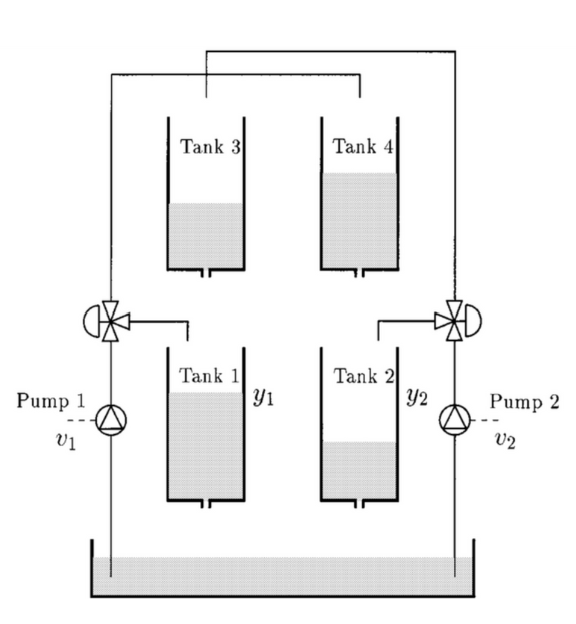

Let us consider the Quadruple-Tank Process. A schematic diagram of the process is shown in the Figure above. The
target is to control the level in the lower two tanks with two pumps. The process inputs are $v_1$ and $v_2$ (input voltages to the pumps) and the outputs are $y_1$ and $y_2$ (water levels in the lower two tanks). Mass balances and Bernoulli’s law yield:

$$
\dfrac{dh_1}{dt} = -\dfrac{a_1}{A_1}\sqrt{2gh_1} + \dfrac{a_3}{A_1}\sqrt{2gh_3} + \dfrac{\gamma_1k_1}{A_1}v_1 = f_1(h_1,h_2,h_3,h_4,v_1,v_2)
$$
$$
\dfrac{dh_2}{dt} = -\dfrac{a_2}{A_2}\sqrt{2gh_2} + \dfrac{a_4}{A_2}\sqrt{2gh_4} + \dfrac{\gamma_2k_2}{A_2}v_2 = f_2(h_1,h_2,h_3,h_4,v_1,v_2)
$$
$$
\dfrac{dh_3}{dt} = -\dfrac{a_3}{A_3}\sqrt{2gh_3} + \dfrac{(1-\gamma_2)k_2}{A_3}v_2 = f_3(h_1,h_2,h_3,h_4,v_1,v_2)
$$
$$
\dfrac{dh_4}{dt} = -\dfrac{a_4}{A_4}\sqrt{2gh_4} + \dfrac{(1-\gamma_1)k_1}{A_4}v_1 = f_4(h_1,h_2,h_3,h_4,v_1,v_2)
$$
where

$A_i$ is a cross-section of Tank i

$a_i$ is a cross-section of outlet hole of Tank i

$h_i$ is a water level.

The voltage applied to Pump $i$ is $v_i$ and the corresponding flow
is $k_iv_i$. The parameters $\gamma_1,\gamma_2\in (0,1)$ are determined from how the valves are set prior to the experiment. The flow to Tank 1
is $\gamma_1k_1v_1$ and the flow to Tank 4 is $(1-\gamma_1)k_1v_1$ and similarly
for Tank 2 and Tank 3. The acceleration of gravity is denoted $g$.
The measured level signals are $k_c h_1$ and $k_c h_2$. The parameter
values of the laboratory process are given in the following table

    A_1, A_3 [cm^2] 28
    A_2, A_4 [cm^2] 32
    a_1, a_3 [cm^2] 0.071
    a_2, a_4 [cm^2] 0.057
    k_c [V/cm] 0.50
    g [cm/s^2] 9.81
    k_1 [cm^3/Vs] 3.33
    k_2 [cm^3/Vs] 3.35
    gamma_1 0.70
    gamma_2 0.60
    
Check the following paper for more details on the model. 
https://www.diva-portal.org/smash/get/diva2:495784/FULLTEXT01.pdf
    
## TODO
1. Linearise the system around the operating point 
$$(h_1^0,h_2^0,h_3^0,h_4^0, v_1^0, v_2^0) = (12.4,12.7,1.8,1.4,3.00,3.00).$$
Pass to shifted variables $x_i = h_i-h_i^0, u_i = v_i - v_i^0.$

2. Is the linear system controllable? Is the linear system observable? Use the Kalman rank test to answer this question.

3. Imagine that one of the pumps is broken and there is no flow through it. Does the system remain controllable?

4. Let us measure the signals $x_3, x_4$ (i.e. matrix $C = \begin{pmatrix}0&0&1&0\\0&0&0&1\end{pmatrix}$) instead of measuring the signals $x_1$ and $x_2.$ Is such a system observable?

**Remark.** The functions control.ctrb and control.obsv from the control system library might be useful to complete this exercise. https://python-control.readthedocs.io/en/0.10.1/generated/control.obsv.html 

### Solution : Ex 3 — TODO 1: Linearization at the operating point

We linearize $\dot h = f(h,v)$ around the operating point
$$
(h_1^0,h_2^0,h_3^0,h_4^0, v_1^0, v_2^0) = (12.4,12.7,1.8,1.4,3.00,3.00).
$$

Define the shifted (deviation) variables
$$
x = h - h^0,\qquad u = v - v^0.
$$

Assuming $(h^0,v^0)$ is an equilibrium (ideally $f(h^0,v^0)=0$), the linearized shifted model is
$$
\dot x \approx A x + B u,
$$
where $A=\left.\dfrac{\partial f}{\partial h}\right|_{(h^0,v^0)}$ and $B=\left.\dfrac{\partial f}{\partial v}\right|_{(h^0,v^0)}$.

For the measured outputs $y_1=k_c h_1,\; y_2=k_c h_2$, the shifted output is
$$
\tilde y = y-y^0 = Cx,\qquad C = k_c\begin{bmatrix}1&0&0&0\\0&1&0&0\end{bmatrix},\quad y^0 = k_c\begin{bmatrix}h_1^0\\ h_2^0\end{bmatrix}.
$$

In [7]:
# TODO 1 (Ex 3): Linearize and shift variables
import numpy as np
import sympy as sp
from IPython.display import display, Markdown

# Parameters (as given in the statement/table)
A1 = A3 = 28.0  # [cm^2]
A2 = A4 = 32.0  # [cm^2]
a1 = a3 = 0.071  # [cm^2]
a2 = a4 = 0.057  # [cm^2]
kc = 0.50        # [V/cm]
g = 9.81         # [cm/s^2]  (If your course uses cm-units consistently, you may want g=981.)
k1 = 3.33        # [cm^3/(V s)]
k2 = 3.35        # [cm^3/(V s)]
gamma1 = 0.70
gamma2 = 0.60

# Operating point
h0 = np.array([12.4, 12.7, 1.8, 1.4], dtype=float)  # [cm]
v0 = np.array([3.00, 3.00], dtype=float)            # [V]

h1_0, h2_0, h3_0, h4_0 = h0
v1_0, v2_0 = v0

# Helper: derivative d/dh sqrt(2 g h) = g / sqrt(2 g h)
def d_sqrt_2gh_dh(h):
    return g / np.sqrt(2.0 * g * h)

# Linearization matrices A = df/dh |_(h0,v0), B = df/dv |_(h0,v0)
A = np.zeros((4, 4), dtype=float)
B = np.zeros((4, 2), dtype=float)

# f1 = -(a1/A1)*sqrt(2gh1) + (a3/A1)*sqrt(2gh3) + (gamma1 k1/A1) v1
A[0, 0] = -(a1 / A1) * d_sqrt_2gh_dh(h1_0)
A[0, 2] = +(a3 / A1) * d_sqrt_2gh_dh(h3_0)
B[0, 0] = (gamma1 * k1) / A1

# f2 = -(a2/A2)*sqrt(2gh2) + (a4/A2)*sqrt(2gh4) + (gamma2 k2/A2) v2
A[1, 1] = -(a2 / A2) * d_sqrt_2gh_dh(h2_0)
A[1, 3] = +(a4 / A2) * d_sqrt_2gh_dh(h4_0)
B[1, 1] = (gamma2 * k2) / A2

# f3 = -(a3/A3)*sqrt(2gh3) + ((1-gamma2) k2/A3) v2
A[2, 2] = -(a3 / A3) * d_sqrt_2gh_dh(h3_0)
B[2, 1] = ((1.0 - gamma2) * k2) / A3

# f4 = -(a4/A4)*sqrt(2gh4) + ((1-gamma1) k1/A4) v1
A[3, 3] = -(a4 / A4) * d_sqrt_2gh_dh(h4_0)
B[3, 0] = ((1.0 - gamma1) * k1) / A4

# Output (shifted): y_tilde = C x, with y = kc*[h1, h2]^T
C = kc * np.array([[1, 0, 0, 0],
                   [0, 1, 0, 0]], dtype=float)
y0 = kc * h0[:2]

def show_matrix(name: str, M: np.ndarray, digits: int = 6):
    display(Markdown(f"**{name}**"))
    display(sp.Matrix(M).evalf(digits))

show_matrix('A', A)
show_matrix('B', B)
show_matrix('C', C)
display(Markdown(f"**y0** = {np.array2string(y0, precision=6, suppress_small=False)}"))

# Final linearized shifted model: xdot = A x + B u, y_tilde = C x

**A**

Matrix([
[-0.00159481,           0,  0.00418585,           0],
[          0, -0.00110699,           0,  0.00333411],
[          0,           0, -0.00418585,           0],
[          0,           0,           0, -0.00333411]])

**B**

Matrix([
[  0.08325,         0],
[        0, 0.0628125],
[        0, 0.0478571],
[0.0312187,         0]])

**C**

Matrix([
[0.5,   0, 0, 0],
[  0, 0.5, 0, 0]])

**y0** = [6.2  6.35]

### Solution — Ex 3, TODO 2 (Kalman rank tests)

For the linearized shifted model $\dot x = Ax + Bu$, controllability is checked by the rank of
$$
\mathcal{C}(A,B)=\begin{bmatrix}B & AB & A^2B & \cdots & A^{n-1}B\end{bmatrix}.
$$

For observability with output $\tilde y = Cx$, we check the rank of
$$
\mathcal{O}(A,C)=\begin{bmatrix}C\\ CA\\ CA^2\\ \vdots\\ CA^{n-1}\end{bmatrix}.
$$

The system is controllable/observable iff the corresponding matrix has full rank $n$.

In [9]:
# TODO 2 (Ex 3): Kalman rank tests for controllability/observability
import numpy as np
import sympy as sp
from IPython.display import display, Markdown

def ctrb(A: np.ndarray, B: np.ndarray) -> np.ndarray:
    n = A.shape[0]
    blocks = [B]
    Ak = np.eye(n)
    for _ in range(1, n):
        Ak = Ak @ A
        blocks.append(Ak @ B)
    return np.concatenate(blocks, axis=1)

def obsv(A: np.ndarray, C: np.ndarray) -> np.ndarray:
    n = A.shape[0]
    blocks = [C]
    Ak = np.eye(n)
    for _ in range(1, n):
        Ak = Ak @ A
        blocks.append(C @ Ak)
    return np.concatenate(blocks, axis=0)

n = A.shape[0]
Ctrb = ctrb(A, B)
Obsv = obsv(A, C)

rank_ctrb = np.linalg.matrix_rank(Ctrb)
rank_obsv = np.linalg.matrix_rank(Obsv)

display(Markdown(f"**rank(Ctrb)** = {rank_ctrb} (n = {n})"))
display(Markdown(f"**rank(Obsv)** = {rank_obsv} (n = {n})"))

display(Markdown(f"**Controllable?** {'YES' if rank_ctrb == n else 'NO'}"))
display(Markdown(f"**Observable?** {'YES' if rank_obsv == n else 'NO'}"))

# (Optional) show the matrices in compact form
display(Markdown("**Ctrb(A,B)**"))
display(sp.Matrix(Ctrb).evalf(6))
display(Markdown("**Obsv(A,C)**"))
display(sp.Matrix(Obsv).evalf(6))

**rank(Ctrb)** = 4 (n = 4)

**rank(Obsv)** = 4 (n = 4)

**Controllable?** YES

**Observable?** YES

**Ctrb(A,B)**

Matrix([
[  0.08325,         0, -0.000132768,  0.000200323,  2.1174e-7,  -1.158e-6, -3.37685e-10,   5.35671e-9],
[        0, 0.0628125,  0.000104087,  -6.95326e-5, -4.6226e-7, 7.69717e-8,   1.66878e-9, -8.52067e-11],
[        0, 0.0478571,            0, -0.000200323,          0, 8.38521e-7,            0,  -3.50992e-9],
[0.0312187,         0, -0.000104087,            0, 3.47037e-7,          0,  -1.15706e-9,            0]])

**Obsv(A,C)**

Matrix([
[         0.5,            0,           0,           0],
[           0,          0.5,           0,           0],
[-0.000797405,            0,  0.00209292,           0],
[           0, -0.000553494,           0,  0.00166706],
[  1.27171e-6,            0, -1.20985e-5,           0],
[           0,    6.1271e-7,           0, -7.40357e-6],
[ -2.02814e-9,            0,  5.59656e-8,           0],
[           0, -6.78262e-10,           0,  2.67272e-8]])

### Solution — Ex 3, TODO 3 (One pump broken)

A “broken pump” means one actuator input has no effect on the state dynamics. In the linear model $\dot x = Ax + Bu$, this can be modeled by setting the corresponding column of $B$ to zero.

We check controllability in both cases:
- Pump 1 broken: first column of $B$ set to zero.
- Pump 2 broken: second column of $B$ set to zero.

In [10]:
# TODO 3 (Ex 3): Controllability if one pump is broken
import numpy as np
from IPython.display import display, Markdown

def ctrb(A: np.ndarray, B: np.ndarray) -> np.ndarray:
    n = A.shape[0]
    blocks = [B]
    Ak = np.eye(n)
    for _ in range(1, n):
        Ak = Ak @ A
        blocks.append(Ak @ B)
    return np.concatenate(blocks, axis=1)

n = A.shape[0]

# Pump 1 broken => v1 has no effect => first column of B is zero
B_p1 = B.copy()
B_p1[:, 0] = 0.0
rank_p1 = np.linalg.matrix_rank(ctrb(A, B_p1))

# Pump 2 broken => v2 has no effect => second column of B is zero
B_p2 = B.copy()
B_p2[:, 1] = 0.0
rank_p2 = np.linalg.matrix_rank(ctrb(A, B_p2))

display(Markdown(f"**Pump 1 broken:** rank(Ctrb) = {rank_p1} (n = {n}) → {'Controllable' if rank_p1 == n else 'NOT controllable'}"))
display(Markdown(f"**Pump 2 broken:** rank(Ctrb) = {rank_p2} (n = {n}) → {'Controllable' if rank_p2 == n else 'NOT controllable'}"))

**Pump 1 broken:** rank(Ctrb) = 3 (n = 4) → NOT controllable

**Pump 2 broken:** rank(Ctrb) = 3 (n = 4) → NOT controllable

### Solution — Ex 3, TODO 4 (Measuring $x_3, x_4$)

Now we change the measurement matrix to measure the upper tanks’ deviation levels:
$$
C_{34}=\begin{bmatrix}0&0&1&0\\0&0&0&1\end{bmatrix},
$$
so that $\tilde y = C_{34}x = (x_3, x_4)^T$. We check observability by the Kalman rank test (rank of the observability matrix).

In [11]:
# TODO 4 (Ex 3): Observability when measuring x3, x4
import numpy as np
import sympy as sp
from IPython.display import display, Markdown

def obsv(A: np.ndarray, C: np.ndarray) -> np.ndarray:
    n = A.shape[0]
    blocks = [C]
    Ak = np.eye(n)
    for _ in range(1, n):
        Ak = Ak @ A
        blocks.append(C @ Ak)
    return np.concatenate(blocks, axis=0)

n = A.shape[0]
C_34 = np.array([[0, 0, 1, 0],
                 [0, 0, 0, 1]], dtype=float)

Obsv_34 = obsv(A, C_34)
rank_obsv_34 = np.linalg.matrix_rank(Obsv_34)

display(Markdown(f"**C_34** = measure (x3, x4)"))
display(sp.Matrix(C_34))

display(Markdown(f"**rank(Obsv(A,C_34))** = {rank_obsv_34} (n = {n})"))
display(Markdown(f"**Observable?** {'YES' if rank_obsv_34 == n else 'NO'}"))

# Optional: show the observability matrix
display(Markdown("**Obsv(A,C_34)**"))
display(sp.Matrix(Obsv_34).evalf(6))

**C_34** = measure (x3, x4)

Matrix([
[0, 0, 1.0,   0],
[0, 0,   0, 1.0]])

**rank(Obsv(A,C_34))** = 2 (n = 4)

**Observable?** NO

**Obsv(A,C_34)**

Matrix([
[0, 0,         1.0,           0],
[0, 0,           0,         1.0],
[0, 0, -0.00418585,           0],
[0, 0,           0, -0.00333411],
[0, 0,  1.75213e-5,           0],
[0, 0,           0,  1.11163e-5],
[0, 0, -7.33417e-8,           0],
[0, 0,           0,  -3.7063e-8]])